# Récupération/Traitement des données de formes d'ondes

> Ce Notebook présente la récupération des formes d'ondes pour le calcul des PPSDs et du déplacement RMS.

---
## Importation des modules

In [1]:
import glob, os
import numpy as np
import pandas as pd
import warnings
import datetime
import sys
from obspy import UTCDateTime, read, read_inventory
from obspy.clients.fdsn import Client
from obspy.clients.fdsn.client import FDSNNoDataException
from obspy.signal import PPSD
from obspy.imaging.cm import pqlx
from seismic_noise import download_noise, process_PPSD, load_PPSD, process_DRMS
import tqdm as tqdm
import shutil
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as pe
from mpl_toolkits.axes_grid1 import make_axes_locatable

---
## Paramètre initiaux

In [2]:
time_zone = "Europe/Brussels"      # Format d'heure
dl_noise = False                   # Téléchargement des données
dl_PPSD = False                     # Téléchargement des PPSDs
proc_PPSD = True                  # Calcul des PPSDs
proc_DRMS = False                  # Calcul du déplacement RMS
delete_MSEED = False               # Suppression des fichiers MSEED
PPSD_FOLDER  = "/media/flavien/Flavien USB/Stages/noise_data/PPSD"
DRMS_FOLDER  = "/media/flavien/Flavien USB/Stages/noise_data/DRMS"
MSEED_FOLDER = "/media/flavien/Flavien USB/Stages/noise_data/MSEED"
respfile = '/media/flavien/Flavien USB/Stages/seismic-noise/DATA/G.CCD.20.BHZ/resp_G.CCD.20.BHZ.xml'
freqs = [(2, 8)]       # Bandes de fréquence à étudier
freq_str = "2.0-8.0"
start_date = "2020-04-09"         # Date de début
end_date = "2021-10-29"           # Date de fin
all_stations = ["G.CCD.20.BHZ"]

In [3]:
start = UTCDateTime(start_date)
end = UTCDateTime(end_date) + 86340
station_str = all_stations[0]
period = [start, end]

---
## Mise en forme des données au bon format

##### On remet les données au bon format mseed pour leur lecture

In [4]:
# folder_in = "/media/flavien/Flavien USB/Stages/seismic-noise/DATA/G.CCD.20.BHZ/G.CCD.20.BHZ"
# folder_out = "/media/flavien/Flavien USB/Stages/seismic-noise/DATA/G.CCD.20.BHZ/MSEED"

# for file in os.listdir(folder_in):
#     st = read('DATA/G.CCD.20.BHZ/G.CCD.20.BHZ/{}'.format(file))
#     tr = st[0]
#     day_str = tr.stats.starttime.strftime("%Y-%m-%d")
#     filename_old = '{}/{}'.format(folder_in, file)
#     filename_new = '{}/{}_G.CCD.20.BHZ.mseed'.format(folder_out, day_str)
#     shutil.copyfile(filename_old, filename_new)

In [5]:
PPSD_FILES  = PPSD_FOLDER  + "/{}/".format(station_str)
DRMS_FILES  = DRMS_FOLDER  + "/{}/".format(station_str)
MSEED_FILES = MSEED_FOLDER + "/{}/".format(station_str)

---
## Calcul des PPSDs

In [6]:
datelist = pd.date_range(start.datetime, min(end, UTCDateTime()).datetime, freq="D")  # Jours à récupérer
client = Client("RESIF")  # Client utilisé pour récupérer les donnée via le webservice
folder_in = MSEED_FILES
folder_out = PPSD_FILES
station_str = all_stations[0]
station = station_str.split(".")

resp = read_inventory(respfile)

if False: 
    # Création du fichier où seront stockées les données
    if not os.path.exists(folder_out):
        os.makedirs(folder_out)

    pbar = tqdm.tqdm(datelist)
    for day in pbar:

        date_str = day.strftime("%Y-%m-%d")
        file_in = "{}{}_{}.mseed".format(folder_in, date_str, station_str)
        file_out = "{}{}_G.CCD.20.BHZ.npz".format(folder_out, date_str)

        try:
            st = read(file_in)
        except:
            continue

        st.attach_response(resp)

        ppsd = PPSD(st[0].stats, metadata=resp,
                    ppsd_length=1800, overlap=0.0,
                    period_smoothing_width_octaves=0.025,
                    period_step_octaves=0.0125,
                    period_limits=(0.008, 50),
                    db_bins=(-200, 20, 0.25))

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            ppsd.add(st)

        ppsd.save_npz(file_out[:-4])

## Lecture des PPSDs

In [7]:
ppsds = {}
    
for file in os.listdir(PPSD_FILES):
    mseedid = file.replace(".npz", "").split("_")[-1]
    filename = PPSD_FILES+file

    if mseedid not in ppsds:
        ppsds[mseedid] = PPSD.load_npz(filename, allow_pickle=True)
    else:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            ppsds[mseedid].add_npz(filename, allow_pickle=True)

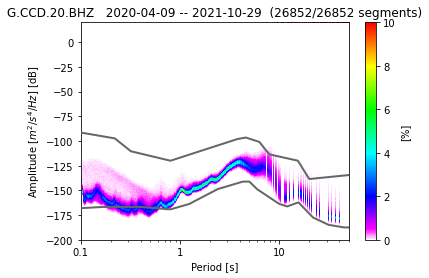

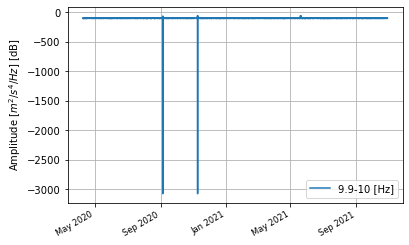

[None]

In [8]:
[ppsd.plot(max_percentage=10, grid=False, period_lim=(0.1,50), show_coverage=False, cmap=pqlx) for mseedid, ppsd in ppsds.items()]
[ppsd.plot_temporal(0.10) for mseedid, ppsd in ppsds.items()]

In [9]:
# [ppsd.plot_spectrogram(clim=(-160,-100), grid=False) for mseedid, ppsd in ppsds.items()]

---
## Calcul du déplacement RMS

In [10]:
if False:
    process_DRMS(ppsds, freqs, DRMS_FOLDER)

In [11]:
dataframe = pd.read_csv("{}/{}.csv".format(DRMS_FOLDER, station_str), index_col=0)
dataframe.index = pd.to_datetime(dataframe.index)
dRMS = dataframe.copy()
dRMS

,2.0-8.0
2020-04-09 13:14:16,2.880874e-11
2020-04-09 13:44:16,2.149386e-11
2020-04-09 14:14:16,5.242104e-11
2020-04-09 14:44:16,2.112852e-11
2020-04-09 15:14:16,1.802926e-11
...,...
2021-10-29 10:30:09,2.891732e-11
2021-10-29 11:00:09,3.518832e-11
2021-10-29 11:30:09,4.538614e-11
2021-10-29 12:00:09,3.883881e-11


Text(0, 0.5, 'Median displacement [nm]')

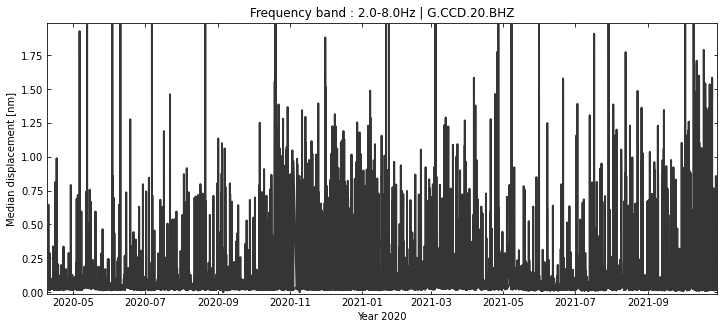

In [15]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.tick_params(direction="in", which="both", top=True, right=True)
ax.set_title("Frequency band : {}Hz | {}".format(freq_str, station_str))
ax.plot(dRMS*1e9, color="#353535", lw=2, zorder=3)
plt.ylim(-1*np.nanquantile(dRMS, 0.01)/1e-9, 2*np.nanquantile(dRMS, 0.99)/1e-9)
ax.set_xlim([datelist[0], datelist[-1]])
ax.set_xlabel("Year 2020")
ax.set_ylabel("Median displacement [nm]")